# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
!pip install nltk

     |████████████████████████████████| 1.5MB 961kB/s eta 0:00:01
  Stored in directory: /home/jovyan/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk


In [1]:
# basic data libraries
import pandas as pd
import numpy as np
import re
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

# scikit-learn modules for pipelining, transformation, model fitting and classification
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report

# nltk-modules for text processing, tokenizing and lemmatizing
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download relevant ntlk packages
nltk.download(["punkt", "stopwords", "wordnet"])

# pickle for python object serialization and storing
import pickle


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# load data from database

engine = create_engine('sqlite:///crisisresponse.db')
df = pd.read_sql_table('messages', engine)
X = df.loc[:,"message"]
Y = df.iloc[:,4:40]

### 2. Write a tokenization function to process your text data

In [3]:
def tokenize(text):
    """
    Tokenize, lemmatize, lower and remove punctuation of input text.

    Input arguments:
        text: Single string with input text 
              Example: 'For today:= this is, a advanced _ example #- String!'
              
    Output:
        output: List of processed string
                Example: ['today', 'advanced', 'example', 'string']
        
    """
    # set text to lower case and remove punctuation
    text = re.sub("[\W_]", " ", text)
    text= text.lower()

    # tokenize words 
    tokens = word_tokenize(text)
    
    # lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # init and remove stopwords
    stop_words = set(stopwords.words('english'))
    output = [lemmatizer.lemmatize(w) for w in tokens if not w in stop_words]

    return output

#### Quick check of function tokenize

In [4]:
tokenize("For today:= this is, a advanced _ example #- String!")

['today', 'advanced', 'example', 'string']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [93]:
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=100)))
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [94]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

print("""
Shape of all elements: \n\t X_train: {}
\t X_test: {}
\t Y_train: {}
\t Y_test: {}""".format(X_train.shape,
                          X_test.shape,
                          Y_train.shape,
                          Y_test.shape))


Shape of all elements: 
	 X_train: (18219,)
	 X_test: (7809,)
	 Y_train: (18219, 36)
	 Y_test: (7809, 36)


In [95]:
# train pipeline
pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip..._score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=None))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

I will use some functions to simplify the process of outputting the classification report

#### Create Functions for testing

In [96]:
def flat_arr_df(two_d_data):
    """
    Flatten array/list of arrays/lists and dataframes to lists.

    Input arguments:
        two_d_data: dataframe or array/list of arrays/lists 
                    Example: [[1,2,3],[4,5,6],[7,8,9]]
              
    Output:
        flat_data: List of flattened Input
                   Example: [1,2,3,4,5,6,7,8,9]
    
    """

    if isinstance(two_d_data, (list, np.ndarray)):
        if isinstance(two_d_data[0], (list, np.ndarray)):
            flat_data = [item for sublist in two_d_data for item in sublist]
        else:
            print("Wrong datatype used, cannot flat this object")
            return ""
    elif isinstance(two_d_data, pd.DataFrame):
            flat_data = list(two_d_data.values.flatten())
    
    return flat_data

def return_multioutput_f1_prec_recall(Y_pred, Y_test, mac_avg=False):
    """
    Output classification report (f1, precision, recall) seperated for every category in
    Multi_Output_Data

    Input arguments:
        Y_pred: dataframe or array/list of arrays/lists 
                    Example: [[1,2,3],[4,5,6],[7,8,9]]
        
        Y_test: dataframe or array/list of arrays/lists 
                    Example: [[1,2,3],[4,5,6],[7,8,9]]
                    
        mac_avg: If True returns Dict with Category names and F1 Score
              
    Output:
        If mac_avg==False: prints precision, recall and f1-score
        If mac_avg==True: returns Dict with Category names and F1 Score
    
    """
    if mac_avg:
        mac_avg_dict = {}
        
    for pred_row, test_row, colname in zip(Y_pred.T, Y_test.to_numpy().T, Y_test.columns):
        if mac_avg:
            mac_avg_dict[colname] = classification_report(pred_row, test_row, output_dict=True)["macro avg"]["f1-score"]
        else:
            print("Report for Category: {}".format(colname))
            print(classification_report(pred_row, test_row))    
    
    if mac_avg:
        return mac_avg_dict
    
def return_flatted_f1_prec_recall(Y_pred, Y_test, mac_avg=False):
    """
    Output classification report (f1, precision, recall) for flatted prediction and test data.

    Input arguments:
        Y_pred: dataframe or array/list of arrays/lists 
                    Example: [[1,2,3],[4,5,6],[7,8,9]]
        
        Y_test: dataframe or array/list of arrays/lists 
                    Example: [[1,2,3],[4,5,6],[7,8,9]]
                    
        mac_avg: If True returns F1-Score
              
    Output:
        If mac_avg==False: prints precision recall and f1-score
        If mac_avg==True: returns F1-Score only
    
    """
    
    flat_Y_pred = flat_arr_df(Y_pred)
    flat_Y_test = flat_arr_df(Y_test)
    if mac_avg:
        return classification_report(flat_Y_pred, flat_Y_test, output_dict=True)["macro avg"]["f1-score"]
    else:
        print(classification_report(flat_Y_pred, flat_Y_test))

#### Quick check of functions flat_arr_df and display_f1_prec_recall

In [97]:
test_data_arr = [[1,2,3],[4,5,6],[7,8,9]]
test_data_df = pd.DataFrame(test_data_arr)
flat_arr_df(test_data_arr)

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [98]:
flat_arr_df(test_data_df)

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [99]:
return_flatted_f1_prec_recall(test_data_arr,test_data_df)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1

   micro avg       1.00      1.00      1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



#### Test real model prediction

In [100]:
Y_pred_01 = pipeline.predict(X_test)

#### Evaluate over whole flattened prediction

In [102]:
return_flatted_f1_prec_recall(Y_pred_01,Y_test)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97    264758
           1       0.54      0.82      0.65     16366

   micro avg       0.95      0.95      0.95    281124
   macro avg       0.76      0.89      0.81    281124
weighted avg       0.96      0.95      0.95    281124



#### Evaluate every Category on it's own

In [116]:
cla_report_rfc_b = pd.Series(return_multioutput_f1_prec_recall(Y_pred_01, Y_test, mac_avg=True))
cla_report_rfc_b = cla_report_rfc_b.to_frame()

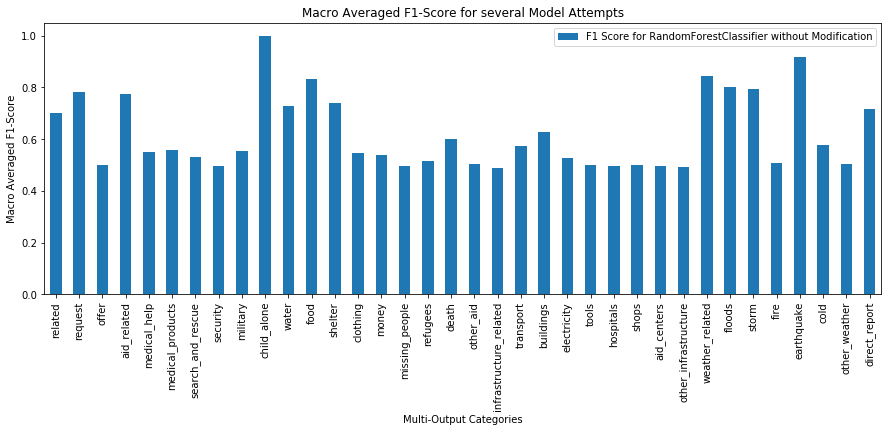

In [187]:
cla_report_rfc_b.rename(columns={0:"F1 Score for RandomForestClassifier without Modification"}, inplace=True)
_ = cla_report_rfc_b.plot(kind="bar", figsize=(15,5))
_ = plt.title("Macro Averaged F1-Score for several Model Attempts")
_ = plt.ylabel("Macro Averaged F1-Score")
_ = plt.xlabel("Multi-Output Categories")

### 6. Improve your model
Use grid search to find better parameters. 

In [61]:
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=100)))
    ])

In [62]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__estimator__bootstrap', 'clf__estimator__class_weight', 'clf__estimator__criterion', 'clf__estimator__max_depth', 'clf__estimator__max_features', 'clf__estimator__max_leaf_nodes', 'clf__estimator__min_impurity_decrease', 'clf__estimator__min_impurity_split', 'clf__estimator__min_samples_leaf', 'clf__estimator__min_samples_split', 'clf__estimator__min_weight_fraction_leaf', 'clf__estimator__n_estimators', 'clf__estimator__n_jobs', 'clf__estimator__oob_score', 'clf__estimator__random_state', 'clf__estimator__verbose', 'clf__estimator__

In [68]:
parameters = {
        'clf__estimator__min_samples_split': [2, 3, 4],
        'clf__estimator__n_estimators': [100, 200, 300],
        'clf__estimator__criterion': ['entropy', 'gini']
    }

cv =  GridSearchCV(pipeline, param_grid=parameters, verbose=3, n_jobs=10)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [69]:
cv.fit(X_train, Y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed: 30.1min
[Parallel(n_jobs=10)]: Done  54 out of  54 | elapsed: 104.1min remaining:    0.0s
[Parallel(n_jobs=10)]: Done  54 out of  54 | elapsed: 104.1min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip..._score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=None))]),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'clf__estimator__min_samples_split': [2, 3, 4], 'clf__estimator__n_estimators': [100, 200, 300], 'clf__estimator__criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [70]:
cv.best_params_

{'clf__estimator__criterion': 'gini',
 'clf__estimator__min_samples_split': 3,
 'clf__estimator__n_estimators': 300}

```
{'clf__estimator__criterion': 'gini',
 'clf__estimator__min_samples_split': 3,
 'clf__estimator__n_estimators': 300}
```

In [167]:
cv.best_estimator_

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip..._score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=None))])

In [119]:
Y_pred_02 = cv.predict(X_test)

In [140]:
return_flatted_f1_prec_recall(Y_pred_02,Y_test)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    258647
           1       0.86      0.96      0.91     22477

   micro avg       0.98      0.98      0.98    281124
   macro avg       0.93      0.97      0.95    281124
weighted avg       0.99      0.98      0.98    281124



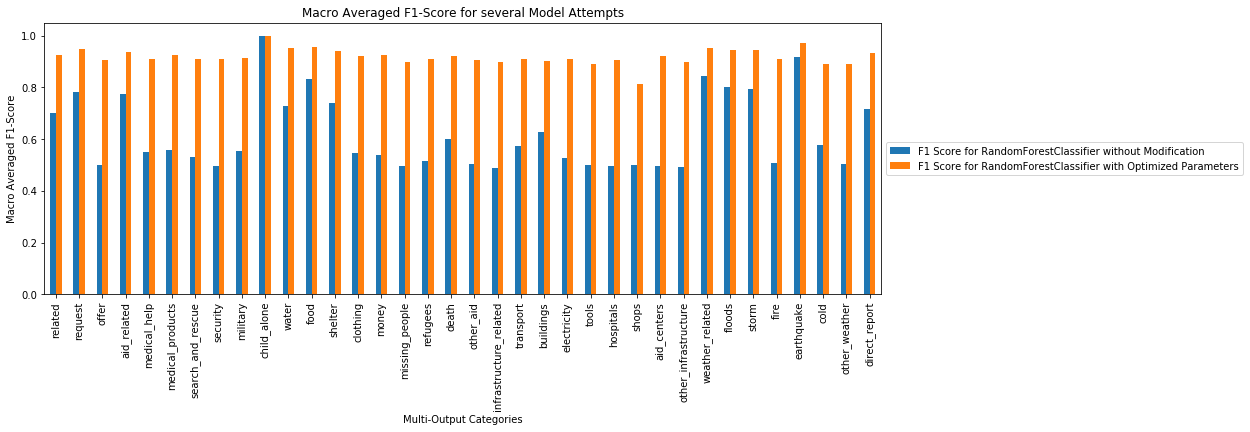

In [186]:
cla_report_rfc_a = pd.Series(return_multioutput_f1_prec_recall(Y_pred_02, Y_test,mac_avg=True))
cla_report_rfc_a = cla_report_rfc_a.to_frame()

cla_report_rfc_a.rename(columns={0:"F1 Score for RandomForestClassifier with Optimized Parameters"}, inplace=True)
cla_report_rfc_a = pd.concat([cla_report_rfc_b, cla_report_rfc_a], axis=1)
_ = cla_report_rfc_a.plot(kind="bar", figsize=(15,5))
_ = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
_ = plt.title("Macro Averaged F1-Score for several Model Attempts")
_ = plt.ylabel("Macro Averaged F1-Score")
_ = plt.xlabel("Multi-Output Categories")

We can see, that the GridsearchCV optimized model seems to be completly overfitted. Therefore it's not very useful to use it on new data and we will ignore it for further examination.

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

#### Adding additional Feature: Message starts/ends with Question term

In [203]:
class MessageIsQuestion(BaseEstimator, TransformerMixin):
    '''
    Extract messages that starts with question word or ends with question mark and
    return DataFrame with 1's for True and 0's for False
    '''
    def __init__(self):
        '''
        Create the Regex Variable for checking
        '''
        # typical englisch question words
        question_words = ["what", "when", "do", "is", "who", "which", "where", "why", "how"]
        # matches question words at beginning of text or questionmarks at the end
        question_reg = "(^"+"("+"|".join(question_words)+")|(\?)$)"
        self.q_reg = re.compile(question_reg)
    
    def message_question(self, text):
        '''
        Will get on text message per execution. After Tokenizing by sentences, it will return 1
        on matching the regex question_reg or 0 for not matching.
        
        Input Arguments:
            text: Single String with message
            
        Output:
            output: Returns 1 if text includes Question and returns 0 when Question doesn't include question
        
        '''
        # tokenize by sentences
        sentence_list =  nltk.sent_tokenize(text)
        for sentence in sentence_list:
            # find pattern question_reg in each sentence
            sentence = sentence.lower()
            if self.q_reg.match(sentence):
                return 1
            else:
                return 0

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        '''
        Will go through single column DataFrame and applies message_question to every message in the row.
        The returning DataFrame holds 1's or 0's whether the message includes question or not.
        
        Input Arguments:
            X: DataFrame with single column or array/list
        
        Output:
            output: Cleaned DataFrame with 1's and 0's for messages
        '''
        
        # apply message_question function to all values in X
        X_tagged = pd.Series(X).apply(self.message_question)
        
        # clean the resulting Dataframe that it can be processed through the pipeline
        df = pd.DataFrame(X_tagged)
        df.fillna(0, inplace=True)
        df = df.astype(int)
        
        return df

There can be issues encountered in the resulting training data:
  * mixed datatypes with floats and boolean values
  * NaN values
  
The arising errors could be resolved reading this post:
  * https://github.com/scikit-learn/scikit-learn/issues/11912

#### Testing new custom transformer

In [206]:
miq = MessageIsQuestion()
output = miq.transform(X_train)

In [207]:
rfc_ct_pipe = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('message_question', MessageIsQuestion())
        ])),

        ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=300,
                                                             min_samples_split=3,
                                                             criterion="gini"))
    )])

In [ ]:
_ = rfc_ct_pipe.fit(X_train, Y_train)

#### Compare RandomForest with and without the custom transformer

In [196]:
Y_pred_03 = rfc_ct_pipe.predict(X_test)

In [191]:
return_flatted_f1_prec_recall(Y_pred_03, Y_test)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97    264407
           1       0.55      0.82      0.66     16717

   micro avg       0.95      0.95      0.95    281124
   macro avg       0.77      0.89      0.81    281124
weighted avg       0.96      0.95      0.95    281124



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


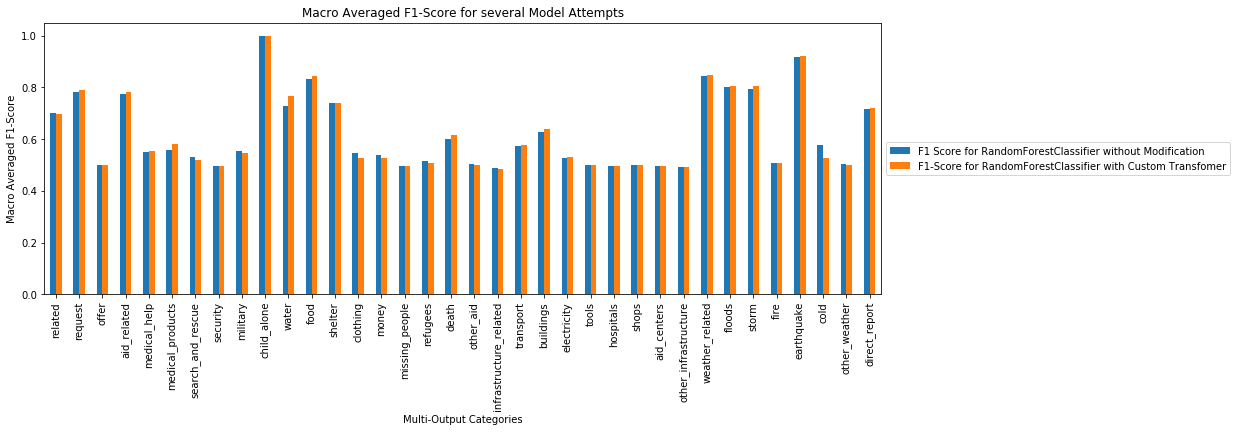

In [192]:
cla_report_rfc_ct=pd.Series(return_multioutput_f1_prec_recall(Y_pred_03, Y_test,mac_avg=True))
cla_report_rfc_ct = cla_report_rfc_ct.to_frame()
cla_report_rfc_ct.rename(columns={0:"F1-Score for RandomForestClassifier with Custom Transfomer"}, inplace=True)
cla_report_rfc_ct = pd.concat([cla_report_rfc_b, cla_report_rfc_ct], axis=1)
_ = cla_report_rfc_ct.plot(kind="bar", figsize=(15,5))
_ = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
_ = plt.title("Macro Averaged F1-Score for several Model Attempts")
_ = plt.ylabel("Macro Averaged F1-Score")
_ = plt.xlabel("Multi-Output Categories")

For some categories the F1-Score has improved but for some others it has decreased. Looking at the flattened summarized evaluation we can see a slightly improvement in the precision. 

### Using Multinominal Naive Bayes

In [130]:
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html?highlight=nlp
from sklearn.naive_bayes import MultinomialNB

In [131]:
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(MultinomialNB()))
    ])

In [132]:
_ = pipeline.fit(X_train, Y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -


#### Compare RandomForest and Multinominal Naive Bayes

In [133]:
Y_pred_04 = pipeline.predict(X_test)

In [134]:
return_flatted_f1_prec_recall(Y_pred_04, Y_test)

              precision    recall  f1-score   support

           0       0.99      0.94      0.97    268904
           1       0.38      0.78      0.51     12220

   micro avg       0.94      0.94      0.94    281124
   macro avg       0.69      0.86      0.74    281124
weighted avg       0.96      0.94      0.95    281124



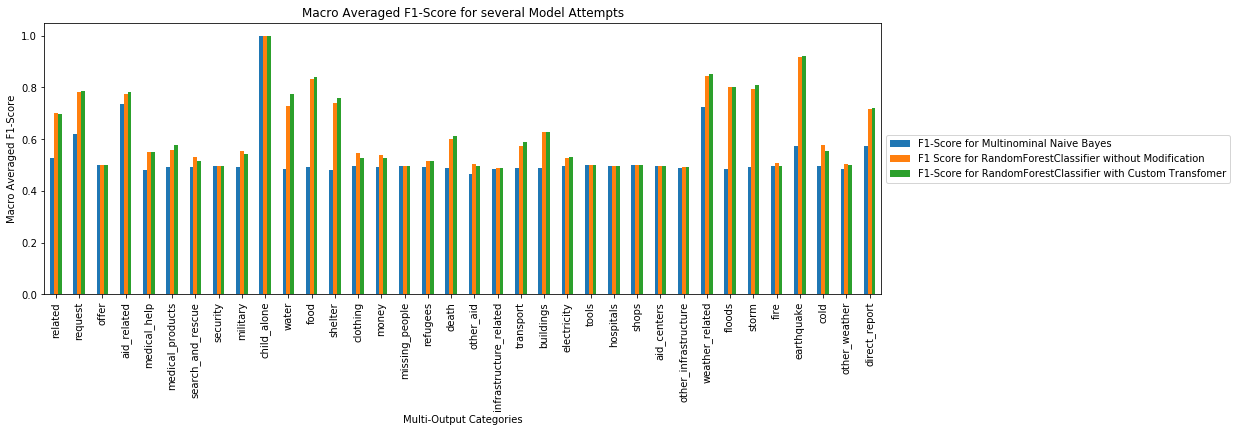

In [184]:
cla_report_mnb=pd.Series(return_multioutput_f1_prec_recall(Y_pred_04, Y_test,mac_avg=True))
cla_report_mnb = cla_report_mnb.to_frame()
cla_report_mnb.rename(columns={0:"F1-Score for Multinominal Naive Bayes"}, inplace=True)
cla_report_mnb = pd.concat([cla_report_mnb, cla_report_rfc_ct], axis=1)
_ = cla_report_mnb.plot(kind="bar", figsize=(15,5))
_ = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
_ = plt.title("Macro Averaged F1-Score for several Model Attempts")
_ = plt.ylabel("Macro Averaged F1-Score")
_ = plt.xlabel("Multi-Output Categories")

We can see that the Multinominal Naive Bayes didn't perform well at all. Therefore my final model will be the RandomForestClassifier with the Custom Transformer.

### 9. Export your model as a pickle file

In [202]:
pickle.dump(rfc_ct_pipe, open("rfc_ct_classifier.pkl", "wb"))

PicklingError: Can't pickle <class '__main__.MessageIsQuestion'>: it's not the same object as __main__.MessageIsQuestion